Processing WR1...


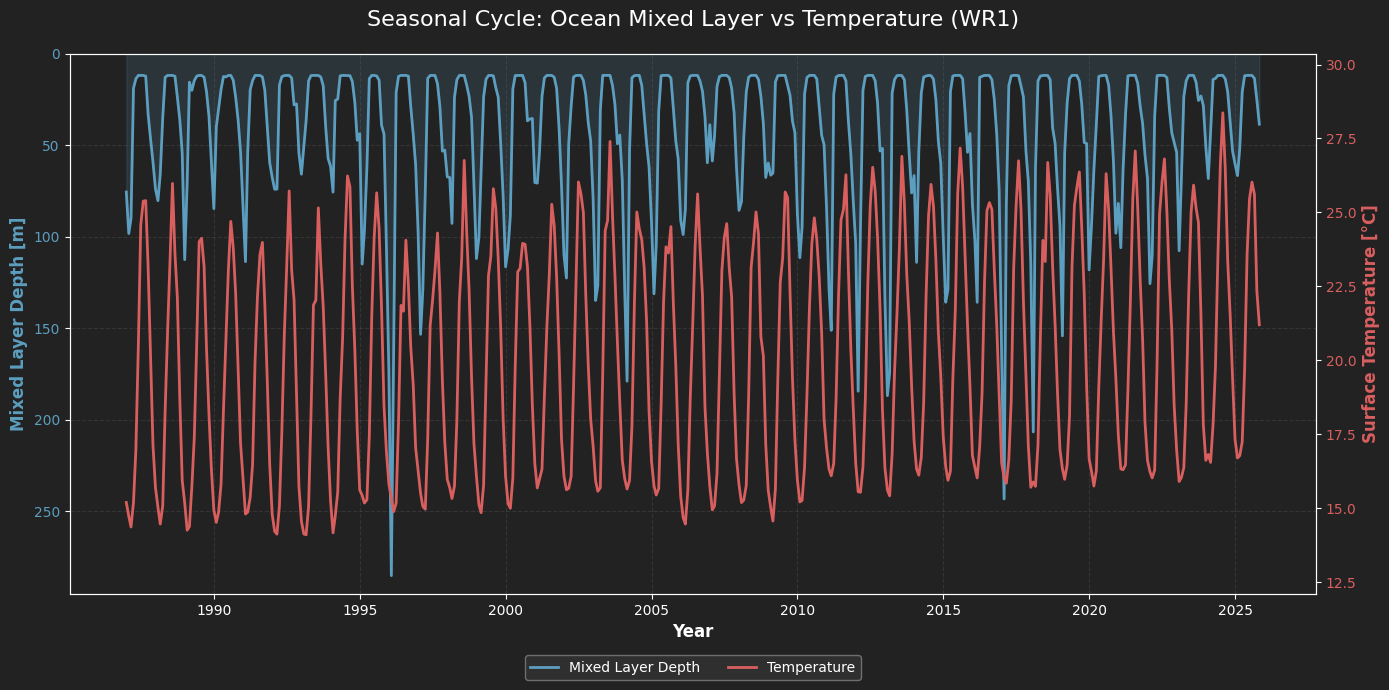

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Helper Function to Find Folders ---
def find_data_path(target_folder, subfolder):
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        if target_folder in os.path.basename(root) and subfolder in dirs:
            return os.path.join(root, subfolder)
        if target_folder in dirs:
             possible_path = os.path.join(root, target_folder, subfolder)
             if os.path.exists(possible_path):
                 return possible_path
    return None

# --- Main Execution for WR1 ---
region_name = "WR1"
print(f"Processing {region_name}...")

# 1. Locate Folders
path_temp_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_mld_dir = find_data_path(region_name, "MIXED_LAYER_DEPTH")

if path_temp_dir and path_mld_dir:
    # 2. Load Data
    path_temp = os.path.join(path_temp_dir, "*.nc")
    path_mld = os.path.join(path_mld_dir, "*.nc")

    ds_temp = xr.open_mfdataset(path_temp, combine='by_coords', chunks={"time": -1})
    ds_mld = xr.open_mfdataset(path_mld, combine='by_coords', chunks={"time": -1})
    ds_combined = xr.merge([ds_mld, ds_temp], join='inner')

    # 3. Process Monthly Means
    if 'depth' in ds_combined['thetao'].coords:
        surface_temp = ds_combined['thetao'].isel(depth=0)
    else:
        surface_temp = ds_combined['thetao']

    mld = ds_combined['mlotst']

    mld_monthly = mld.resample(time='1MS').mean().load()
    temp_monthly = surface_temp.resample(time='1MS').mean().load()

    # 4. Plotting
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('#222222')
    ax1.set_facecolor('#222222')

    # Left Axis: MLD
    color_mld = '#5c9ebf'
    ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
    ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontsize=12, fontweight='bold')
    ax1.fill_between(mld_monthly.time, mld_monthly, 0, color=color_mld, alpha=0.15)
    ax1.plot(mld_monthly.time, mld_monthly, color=color_mld, linewidth=2, label='Mixed Layer Depth')
    ax1.tick_params(axis='y', labelcolor=color_mld, colors='white')
    ax1.tick_params(axis='x', colors='white')
    ax1.invert_yaxis()
    ax1.set_ylim(float(mld_monthly.max()) + 10, 0)

    # Right Axis: Temperature
    ax2 = ax1.twinx()
    color_temp = '#d95f5f'
    ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontsize=12, fontweight='bold')
    ax2.plot(temp_monthly.time, temp_monthly, color=color_temp, linewidth=2, label='Temperature')
    ax2.tick_params(axis='y', labelcolor=color_temp, colors='white')

    # Smart Limits
    min_temp = float(temp_monthly.min()) - 2
    max_temp = float(temp_monthly.max()) + 2
    ax2.set_ylim(min_temp, max_temp)

    # Title & Legend
    plt.title(f"Seasonal Cycle: Ocean Mixed Layer vs Temperature ({region_name})", fontsize=16, color='white', pad=20)
    ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
               loc='upper center', bbox_to_anchor=(0.5, -0.1),
               ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

    plt.tight_layout()
    plt.show()
else:
    print(f"Error: Could not find data folders for {region_name}.")

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file
path = r"C:\Users\panos\PycharmProjects\PythonProject\WR1-20251125T132713Z-1-001\WR1\AQUACULTURE_WR1.xlsx"

# 1. Try reading directly as CSV (since we know it's comma-separated)
#    If this fails, it will print the specific error (e.g., PermissionError, ParserError).
df = pd.read_csv(path)

# -----------------------------
# Preprocessing
# -----------------------------
# Create Date column
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))

# Aggregate data by Date
monthly_stats = df.groupby('Date')[['Mortality(#)', 'Initial_Fish(#)', 'Input_Fish(#)', 'Net_Transfer_In(#)']].sum()

# Calculate the Total Population at Risk
monthly_stats['Total_Start_Fish'] = (
    monthly_stats['Initial_Fish(#)'] +
    monthly_stats['Input_Fish(#)'] +
    monthly_stats['Net_Transfer_In(#)']
)

# Calculate Mortality Rate (%)
monthly_stats['Mortality_Rate'] = (monthly_stats['Mortality(#)'] / monthly_stats['Total_Start_Fish']) * 100
monthly_stats['Mortality_Rate'] = monthly_stats['Mortality_Rate'].fillna(0)

# -----------------------------
# Plot Mortality Rate over time
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(monthly_stats.index, monthly_stats['Mortality_Rate'], marker='o', color='red')
plt.title("Monthly Mortality Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Mortality Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

EmptyDataError: No columns to parse from file

Processing Correlation for WR1...
Found Ocean Data: .\Data\WR1\OCEAN_TEMPERATURE
Found Atmos Data: .\Data\WR1\ATMOSPHERIC_DATA_WR1_1985_2023.csv
Loading Ocean Temperature...
Loading Atmospheric Data...


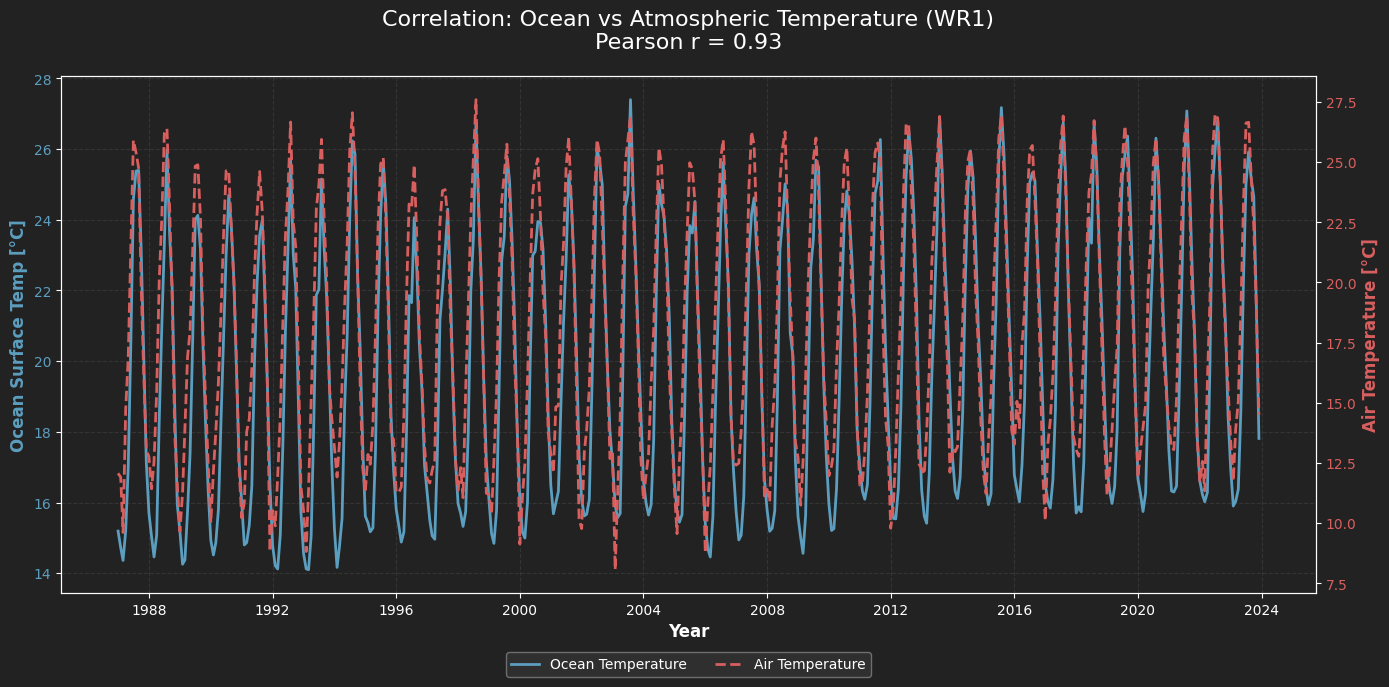

In [11]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from scipy import stats

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
region_name = "WR1"  # Change to "ER1" or "SR1" as needed
atmos_filename_pattern = "ATMOSPHERIC_DATA" # Part of the filename to look for

print(f"Processing Correlation for {region_name}...")

# --- Helper Function to Find Folders/Files ---
def find_data_path(target_folder, subfolder_or_file):
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        # Case 1: subfolder inside region folder (e.g., WR1/OCEAN_TEMPERATURE)
        if target_folder in os.path.basename(root) and subfolder_or_file in dirs:
            return os.path.join(root, subfolder_or_file)

        # Case 2: File inside region folder (e.g., WR1/ATMOSPHERIC_DATA...csv)
        if target_folder in os.path.basename(root):
            for file in files:
                if subfolder_or_file in file:
                    return os.path.join(root, file)

        # Case 3: Direct check if path exists
        possible_path = os.path.join(root, target_folder, subfolder_or_file)
        if os.path.exists(possible_path):
            return possible_path
    return None

# 1. Locate Data
path_ocean_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_atmos_file = find_data_path(region_name, atmos_filename_pattern)

if path_ocean_dir and path_atmos_file:
    print(f"Found Ocean Data: {path_ocean_dir}")
    print(f"Found Atmos Data: {path_atmos_file}")

    # 2. Load Ocean Temperature (NetCDF)
    print("Loading Ocean Temperature...")
    path_nc = os.path.join(path_ocean_dir, "*.nc")
    ds_temp = xr.open_mfdataset(path_nc, combine='by_coords', chunks={"time": -1})

    # Select Surface Temperature (Depth = 0)
    # Robust check for dimension names (depth vs lev)
    if 'depth' in ds_temp.dims:
        surface_temp = ds_temp['thetao'].isel(depth=0)
    elif 'lev' in ds_temp.dims:
        surface_temp = ds_temp['thetao'].isel(lev=0)
    else:
        surface_temp = ds_temp['thetao']

    # Handle lat/lon if they exist (spatial mean)
    if 'lat' in surface_temp.dims and 'lon' in surface_temp.dims:
        surface_temp = surface_temp.mean(dim=['lat', 'lon'])

    # Resample Ocean to Monthly Mean
    ocean_monthly = surface_temp.resample(time='1MS').mean().compute()

    # 3. Load Atmospheric Data (CSV)
    print("Loading Atmospheric Data...")
    df_atmos = pd.read_csv(path_atmos_file)

    # Clean column names (strip whitespace)
    df_atmos.columns = [c.strip() for c in df_atmos.columns]

    # Parse Dates (Format: 01-01-85 3:00 -> DD-MM-YY HH:MM)
    # Adjust format string if your data differs
    try:
        df_atmos['time'] = pd.to_datetime(df_atmos['time'], format='%d-%m-%y %H:%M')
    except:
        # Fallback for standard ISO format
        df_atmos['time'] = pd.to_datetime(df_atmos['time'])

    # Identify Air Temperature Column (handles typos like 'Tempertaure')
    air_temp_col = [c for c in df_atmos.columns if 'temp' in c.lower() and 'air' in c.lower()]
    if air_temp_col:
        col_name = air_temp_col[0]
        # Resample Atmos to Monthly Mean
        # We assume the column is numeric. If "SR1" text is mixed in, ensure you filter it out or set index first.
        atmos_monthly = df_atmos.set_index('time')[[col_name]].resample('1MS').mean()
    else:
        raise ValueError("Could not find Air Temperature column in CSV.")

    # 4. Merge Datasets
    # Convert Atmos DataFrame to Xarray for easy alignment
    ds_atmos = xr.Dataset.from_dataframe(atmos_monthly)
    ds_combined = xr.merge([ocean_monthly.rename('Ocean_Temp'), ds_atmos.rename({col_name: 'Air_Temp'})], join='inner')

    # Drop NaNs to ensure clean plotting
    ds_combined = ds_combined.dropna(dim='time')

    # 5. Plotting (Your Custom Style)
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('#222222')
    ax1.set_facecolor('#222222')

    # Left Axis: Ocean Temperature
    color_ocean = '#5c9ebf' # Blue-ish
    ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
    ax1.set_ylabel('Ocean Surface Temp [°C]', color=color_ocean, fontsize=12, fontweight='bold')
    ax1.plot(ds_combined.time, ds_combined['Ocean_Temp'], color=color_ocean, linewidth=2, label='Ocean Temperature')
    ax1.tick_params(axis='y', labelcolor=color_ocean, colors='white')
    ax1.tick_params(axis='x', colors='white')

    # Right Axis: Atmospheric Temperature
    ax2 = ax1.twinx()
    color_air = '#d95f5f' # Red-ish
    ax2.set_ylabel('Air Temperature [°C]', color=color_air, fontsize=12, fontweight='bold')
    ax2.plot(ds_combined.time, ds_combined['Air_Temp'], color=color_air, linewidth=2, linestyle='--', label='Air Temperature')
    ax2.tick_params(axis='y', labelcolor=color_air, colors='white')

    # Title & Correlation Stats
    r_val = xr.corr(ds_combined['Ocean_Temp'], ds_combined['Air_Temp'], dim='time').values
    plt.title(f"Correlation: Ocean vs Atmospheric Temperature ({region_name})\nPearson r = {r_val:.2f}", fontsize=16, color='white', pad=20)

    ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

    # Combined Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
               loc='upper center', bbox_to_anchor=(0.5, -0.1),
               ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

    plt.tight_layout()
    plt.show()

else:
    print(f"Error: Could not find data folders/files for {region_name}.")
    print("Please check that your folders are named 'OCEAN_TEMPERATURE' and your CSV file contains 'ATMOSPHERIC_DATA'.")

--- Processing WR1: MLD vs Ocean Temperature ---
Loading NetCDF files...
Calculating Monthly Means...
Correlation (r): -0.615


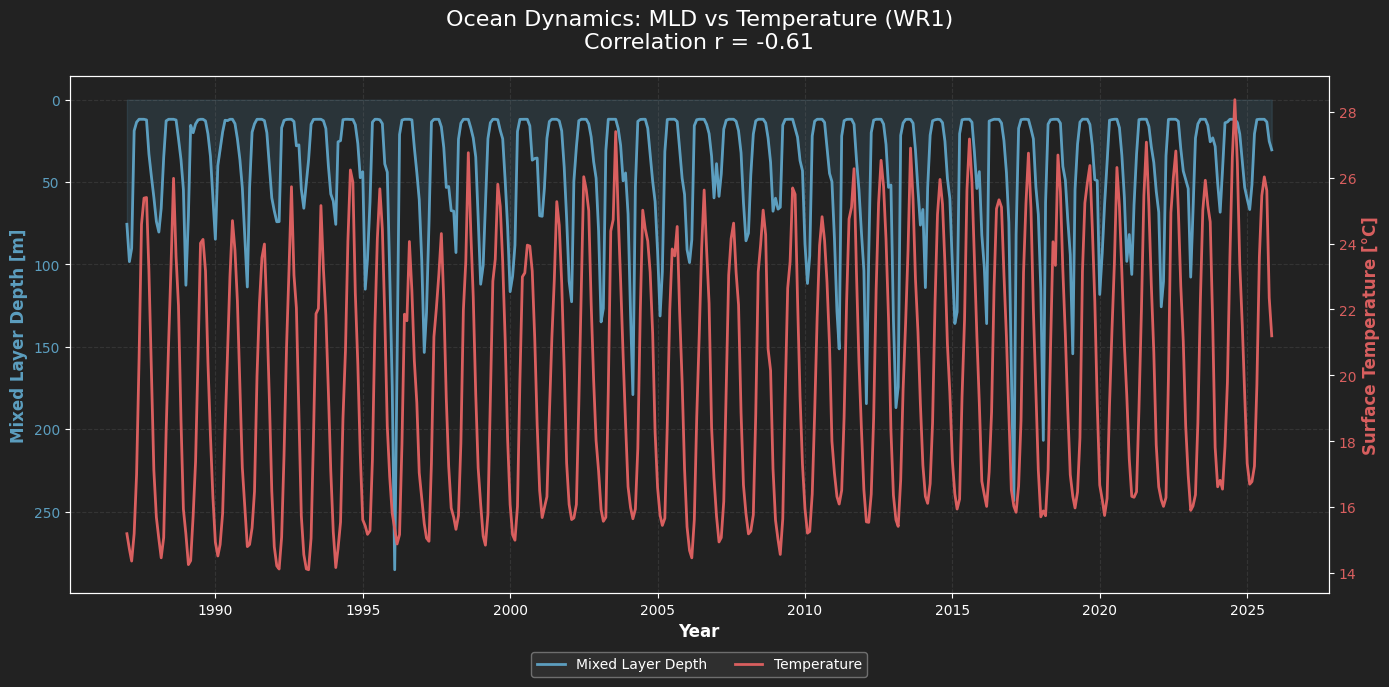

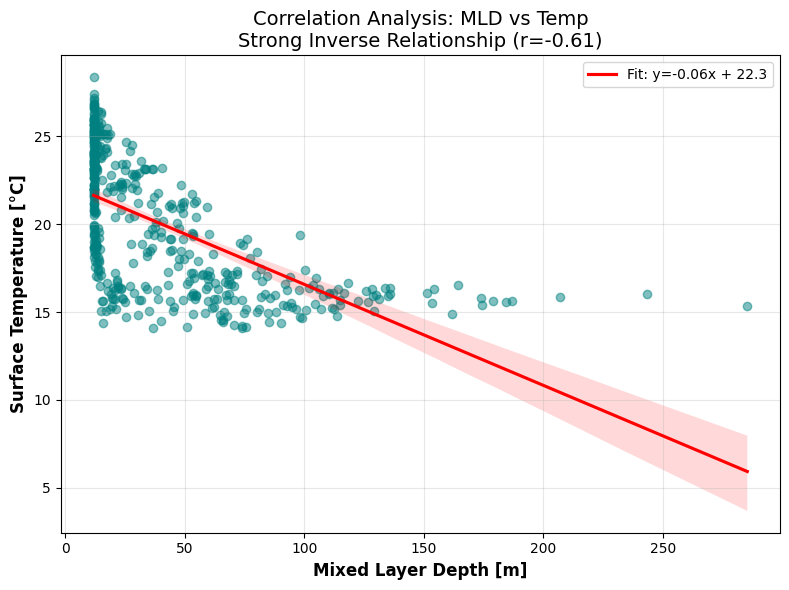

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import numpy as np

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
region_name = "WR1"  # Change to "ER1" or "SR1" as needed

# --- Helper Function to Find Folders ---
def find_data_path(target_folder, subfolder):
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        if target_folder in os.path.basename(root) and subfolder in dirs:
            return os.path.join(root, subfolder)
        if target_folder in dirs:
             possible_path = os.path.join(root, target_folder, subfolder)
             if os.path.exists(possible_path):
                 return possible_path
    return None

print(f"--- Processing {region_name}: MLD vs Ocean Temperature ---")

# 1. Locate Folders
path_temp_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_mld_dir = find_data_path(region_name, "MIXED_LAYER_DEPTH")

if path_temp_dir and path_mld_dir:
    # 2. Load Data
    print("Loading NetCDF files...")
    path_temp = os.path.join(path_temp_dir, "*.nc")
    path_mld = os.path.join(path_mld_dir, "*.nc")

    # Load and combine
    ds_temp = xr.open_mfdataset(path_temp, combine='by_coords', chunks={"time": -1})
    ds_mld = xr.open_mfdataset(path_mld, combine='by_coords', chunks={"time": -1})

    # 3. Process Variables
    # Select Surface Temperature
    if 'depth' in ds_temp['thetao'].dims:
        surface_temp = ds_temp['thetao'].isel(depth=0)
    elif 'lev' in ds_temp['thetao'].dims:
        surface_temp = ds_temp['thetao'].isel(lev=0)
    else:
        surface_temp = ds_temp['thetao']

    # Spatial Mean (if lat/lon exist)
    if 'lat' in surface_temp.dims:
        surface_temp = surface_temp.mean(dim=['lat', 'lon'])

    mld = ds_mld['mlotst']
    if 'lat' in mld.dims:
        mld = mld.mean(dim=['lat', 'lon'])

    # Resample to Monthly Means
    print("Calculating Monthly Means...")
    mld_monthly = mld.resample(time='1MS').mean().compute()
    temp_monthly = surface_temp.resample(time='1MS').mean().compute()

    # Align Data
    ds_combined = xr.merge([mld_monthly.rename('MLD'), temp_monthly.rename('Temp')], join='inner')
    ds_combined = ds_combined.dropna(dim='time')

    # 4. Calculate Correlation
    x = ds_combined['MLD'].values
    y = ds_combined['Temp'].values

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f"Correlation (r): {r_value:.3f}")

    # --- PLOT 1: Improved Time Series (Dark Theme) ---
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('#222222')
    ax1.set_facecolor('#222222')

    # Left Axis: MLD
    color_mld = '#5c9ebf' # Cyan-Blue
    ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
    ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontsize=12, fontweight='bold')
    ax1.fill_between(ds_combined.time, ds_combined['MLD'], 0, color=color_mld, alpha=0.15)
    ax1.plot(ds_combined.time, ds_combined['MLD'], color=color_mld, linewidth=2, label='Mixed Layer Depth')
    ax1.tick_params(axis='y', labelcolor=color_mld, colors='white')
    ax1.tick_params(axis='x', colors='white')
    ax1.invert_yaxis() # Deep MLD goes down

    # Right Axis: Temperature
    ax2 = ax1.twinx()
    color_temp = '#d95f5f' # Salmon-Red
    ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontsize=12, fontweight='bold')
    ax2.plot(ds_combined.time, ds_combined['Temp'], color=color_temp, linewidth=2, label='Temperature')
    ax2.tick_params(axis='y', labelcolor=color_temp, colors='white')

    plt.title(f"Ocean Dynamics: MLD vs Temperature ({region_name})\nCorrelation r = {r_value:.2f}", fontsize=16, color='white', pad=20)
    ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

    # Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

    plt.tight_layout()
    plt.show()

    # --- PLOT 2: Scatter Correlation (Scientific Style) ---
    # Switch back to white style for the scatter plot as it's often used for reports
    plt.style.use('default')
    plt.figure(figsize=(8, 6))

    # Regression Plot
    sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5, 'color':'teal'}, line_kws={'color':'red', 'label':f'Fit: y={slope:.2f}x + {intercept:.1f}'})

    plt.xlabel('Mixed Layer Depth [m]', fontsize=12, fontweight='bold')
    plt.ylabel('Surface Temperature [°C]', fontsize=12, fontweight='bold')
    plt.title(f"Correlation Analysis: MLD vs Temp\nStrong Inverse Relationship (r={r_value:.2f})", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print(f"Error: Could not find data folders for {region_name}.")